In [1]:
import pandas as pd
import seaborn
import numpy as np

In [4]:
INPUT_FP = "../data/raw/"

# Get the data

## Train dataset, containing patients' idx, the date and KT results.
We will get the data, estimate the number of entries, view some samples, check the data for NaNs and plot the results' distribution

In [5]:
train = pd.read_csv(INPUT_FP + "data_for_science_KT_train.csv", date_parser="DATE")
train.sample(5)

,idx,DATE,KT_RESULT
84128,27089,2020-05-14,КТ-1
54173,688610,2020-04-29,КТ-2
74765,575584,2020-05-09,КТ-3
51193,670164,2020-04-27,КТ-0
86748,130869,2020-05-15,КТ-0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132289 entries, 0 to 132288
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   idx        132289 non-null  int64 
 1   DATE       132289 non-null  object
 2   KT_RESULT  132289 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.0+ MB


In [68]:
# We check the shape of our data and check at the same time if there are duplicate entries there
train.shape, train.shape == train.drop_duplicates().shape

((132289, 3), True)

In [69]:
# We check for NaNs
pd.DataFrame(np.sum(train.isna()))

,0
idx,0
DATE,0
KT_RESULT,0


In [70]:
# We check for same idx
np.sum(np.where(train[["idx"]].value_counts() > 1, 1, 0))

18202

<AxesSubplot:>

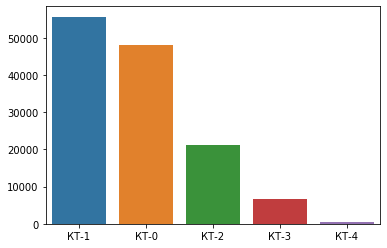

In [71]:
# We plot the results' distribution
seaborn.barplot(x=train["KT_RESULT"].unique(), y=train[["KT_RESULT"]].value_counts())

We can see, that the dataset contains no duplicates, no NaN values. Some patients are more than once to see on the list, getting thier results on different dates. There is also a certain disbalance in the resulting column.

## Test dataset, containing patients' idx and the date. We need to predict KT results.
The same way, as above, we download, estimate size, check for NaNs.

In [72]:
test = pd.read_csv(INPUT_FP + "data_for_science_KT_evaluate.csv", date_parser="DATE")
test.sample(5)

,idx,DATE,KT_RESULT
26157,177825,2020-05-27,NaN
5639,13762,2020-05-19,NaN
30843,73283,2020-06-16,NaN
3426,84424,2020-05-07,NaN
23363,34684,2020-05-19,NaN


In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33080 entries, 0 to 33079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   idx        33080 non-null  int64  
 1   DATE       33080 non-null  object 
 2   KT_RESULT  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 775.4+ KB


In [74]:
# We check the shape of our data and check at the same time if there are duplicate entries there
test.shape, test.shape == test.drop_duplicates().shape

((33080, 3), False)

In [75]:
# We count duplicates in our data
test.shape[0] - test.drop_duplicates().shape[0]

43

In [76]:
# We check for NaNs
pd.DataFrame(np.sum(test.drop(["KT_RESULT"], axis=1).isna()))

,0
idx,0
DATE,0


We can see, that some duplicating entries exist in the test dataset, but still no NaNs are given

## Some datasets, giving us additional info

### Deaths, occuring to some patients

In [77]:
deaths = pd.read_csv(
    INPUT_FP + "data_for_science_death_2020-07-27.csv",
    delimiter=";",
    date_parser="DEATH_DATE"
)
deaths.sample(5)

,idx,DEATH_DATE
1874,753984,2020-05-05
14086,87484,2020-07-13
10673,83483,2020-06-19
10467,351679,2020-06-18
12277,505632,2020-06-29


In [79]:
deaths.shape

(14110, 2)

Let's find intersections with the original dataframes considering, that there are similar idx in the column on which we merge dataframes. To facilitate our furthter exploration and save time, the intersection between other additional datasets and train/test have been prooved to exist (so it won't be done in this notebook).

In [88]:
deaths.merge(train, how="right", on="idx")["DEATH_DATE"].dropna().shape[0]

1391

In [89]:
deaths.merge(test, how="right", on="idx")["DEATH_DATE"].dropna().shape[0]

386

So we can get some additional information. This additional information does not cover the whole dataset. So we should choose strategy to cover the appearing NaNs. For further use, we will mark those, who died we will extract some features from their death date, the entries will be marked in a special column with "1", others and the features to be extracted would be transfromed to "0".

### The questioning results

In [91]:
questioning = pd.read_csv(
    INPUT_FP + "data_for_science_questions_2020-07-27.csv",
    sep=";",
)
questioning.sample(5)

,idx,pd_id,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель
93302,438157,3688018,Нет,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN
2118,213597,2413879,Нет,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN
118810,437113,4004376,Нет,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN
115351,488451,3969955,Нет,Нет,Да,Нет,NaN,NaN,NaN,NaN,NaN
13168,105080,2610131,Нет,Нет,Да,Нет,NaN,NaN,NaN,NaN,NaN


In [96]:
questioning.shape[0]

142033

In [97]:
pd.DataFrame(questioning.isna().sum(axis=0)).T

,idx,pd_id,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель
0,0,0,2,2,2,2,126700,126700,126700,126700,126700


### The diagnois

In [100]:
diagnosis = pd.read_csv(
    INPUT_FP + "data_for_science_diagnoses_2020-07-27.csv",
    sep=";"
)
diagnosis.sample(5)

,idx,DATE,DIAGNOSIS
154143,487067,2019-09-23,J31.2
557027,744226,2020-03-20,E11.9
860623,26818,2020-05-15,J12.9
67273,474723,2019-07-03,J34.2
1040600,806568,2020-06-04,I25.1


In [104]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257754 entries, 0 to 1257753
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   idx        1257754 non-null  int64 
 1   DATE       1257754 non-null  object
 2   DIAGNOSIS  1257754 non-null  object
dtypes: int64(1), object(2)
memory usage: 28.8+ MB


In [110]:
pd.DataFrame(diagnosis.isna().sum(axis=0)).T

,idx,DATE,DIAGNOSIS
0,0,0,0


In [109]:
diagnosis["DIAGNOSIS"].nunique()

333

As it is to see, there are plenty diagnoisis in our dataset. But according to the International Classification of Diseases (ICD), we can make this list much shorter by the disease group, paying attention to the 